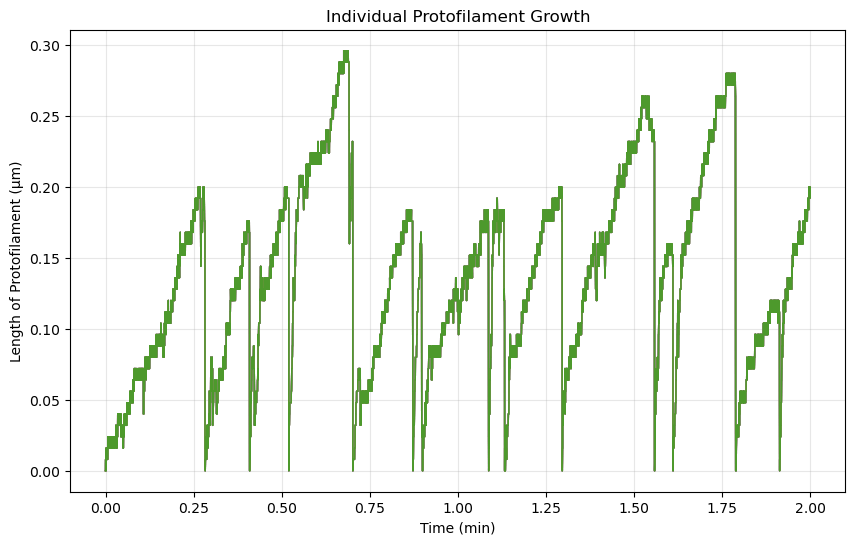

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math



# ---------------------------
# SIMULATION PARAMETERS
# ---------------------------
grid_width, grid_height = 13, 200     # Size of lattice
tubulin_concentration_uM = 10     # Concentration of tubulin in µM

k_plus = 2     # attachment rate in (µM*s)-1

dGLat = -5.7     # free energy of a lateral bond, unitless
dGLong = -6.8     # free energy of a lateral bond, unitless
dGKink = 2.5     # free energy of a lateral bond, unitless

# calculation of k_minus using equation from Van Buren paper
def calc_k_minus(dG):
    return k_plus * tubulin_concentration_uM * math.exp(dG)

k_off_0 = calc_k_minus(dGLong) * 100000     # off rate for GTP with 0 neighbors in s-1
k_off_1 = calc_k_minus(dGLong + dGLat) * 100000     # off rate for GTP with 1 neighbor in s-1
k_off_2 = calc_k_minus(dGLong + (dGLat * 2)) * 100000     # off rate for GTP with 2 neighbors in s-1
k_off_0_h = calc_k_minus(dGLong) * 100000000     # off rate for GDP with 0 neighbors in s-1
k_off_1_h = calc_k_minus(dGLong + dGLat + dGKink) * 100000000     # off rate for GDP with 1 neighbor in s-1
k_off_2_h = calc_k_minus(dGLong + (dGLat * 2) + dGKink) * 100000000     # off rate for GDP with 2 neighbors in s-1

k_h = .95     # hydrolysis rate in s-1

t_cut = 120.0    # max time, represents 2 minutes



''' 
---------------------------
 INITIALIZE_LATTICE
 
 Purpose:
   Create the lattice representing the microtubule with the given values grid_width and grid_height and the height tracking array. 
 
 Parameters:
   - NONE

 Returns: 
   - lattice: 2D array of size grid_width x grid_height filled with empty sites
   - heights: 1D array of size grid_width filled with 0
---------------------------
'''
def initialize_lattice():
    lattice = -np.ones((grid_width, grid_height), dtype=int)     # set grid to empty sites
    lattice[:, 0] = 0     # set template strand to filled with GTP
    heights = np.zeros(grid_width, dtype=int)     # set height tracking array to 0
    return lattice, heights




''' 
---------------------------
 CLASSIFY_ATTACH_SITES

 Purpose:
   Find the lowest unoccupied site in each column of the lattice to determine possible sites for attachment and store in array. 
 
 Parameters:
   - lattice: 2D array representing microtubule
   - heights: 1D array holding number of subunits per column of grid

 Returns: 
   - attach: 1D array of coordinates of lowest unoccupied sites
---------------------------
'''
def classify_attach_sites(lattice, heights):
    attach = []
    for x in range(grid_width):
        y = heights[x] + 1     # first unoccupied site
        if y < grid_height and y > 0 and lattice[x, y] == -1:     # ensure within boundaries of grid
            attach.append((x, y))
    return attach



''' 
---------------------------
 CLASSIFY_DETACH_SITES

 Purpose:
   Find the highest occupied site in each column of the lattice to determine possible sites for detachment and store in array. 
   Split into six arrays for sites of different states.
 
 Parameters:
   - lattice: 2D array representing microtubule
   - heights: 1D array holding number of subunits per column of grid

 Returns: 
   - detach_0: 1D array of coordinates of highest occupied sites of GTP with 0 neighbors
   - detach_1: 1D array of coordinates of highest occupied sites of GTP with 1 neighbor
   - detach_2: 1D array of coordinates of highest occupied sites of GTP with 2 neighbors
   - detach_0_h: 1D array of coordinates of highest occupied sites of GDP with 0 neighbors
   - detach_1_h: 1D array of coordinates of highest occupied sites of GDP with 1 neighbor
   - detach_2_h: 1D array of coordinates of highest occupied sites of GDP with 2 neighbors
---------------------------
'''
def classify_detach_sites(lattice, heights):
    detach_0, detach_1, detach_2 = [], [], []     # holds GTP sites
    detach_0_h, detach_1_h, detach_2_h = [], [], []     # holds GDP sites
    for x in range(grid_width):
        y = heights[x]     # find highest occupied site
        if y > 0:
            left = (x - 1) % grid_width
            right = (x + 1) % grid_width
            neighbors = int(lattice[left, y] != -1) + int(lattice[right, y] != -1)     # count number of neighbors
            if lattice[x, y] == 0:     # if GTP
                if neighbors == 0: detach_0.append((x, y))
                elif neighbors == 1: detach_1.append((x, y))
                else: detach_2.append((x, y))
            elif lattice[x, y] == 1 or lattice[x, y] == 2:     # if GDP or tagged GTP, representing GTP with weakened interactions
                if neighbors == 0: detach_0_h.append((x, y))
                elif neighbors == 1: detach_1_h.append((x, y))
                else: detach_2_h.append((x, y))
    return detach_0, detach_1, detach_2, detach_0_h, detach_1_h, detach_2_h




''' 
---------------------------
 CLASSIFY_GTP_SITES

 Purpose:
   Find all GTP-filled sites, represented by a 0 or 2 in the site. 
 
 Parameters:
   - lattice: 2D array representing microtubule
   - heights: 1D array holding number of subunits per column of grid

 Returns: 
   - GTP : 1D array of coordinates of GTP sites
---------------------------
'''
def classify_GTP_sites(lattice, heights):
    GTP = []
    for x in range(grid_width):
        for y in range(1, heights[x]):
            if (lattice[x, y] == 0 or lattice[x, y] == 2) and lattice[x, y+1] != -1:   # find GTP sites in range of occupied sites
                GTP.append((x, y))
    return GTP




''' 
---------------------------
 RUN_SIMULATION

 Purpose:
   Use above values and functions to represent microtubule assembly using Gillespie algorithm. 
 
 Parameters:
   - NONE

 Returns: 
   - column_growth_history: 2D array containing record of heights of each column after each event occurred in simulation.
   - times: 1D array containing current time after each event occurred in simulation.
---------------------------
'''
def run_simulation():
    lattice, heights = initialize_lattice()
    column_growth_history = [heights.copy()]     # add initial heights of 0 to record of column growth
    times = [0.0]     # set first time in time record to 0
    current_time = 0.0     # set current time to 0
    while current_time < t_cut:
        '''
        Setting sites
        '''
        attach = classify_attach_sites(lattice, heights)     # store attachment sites
        detach_0, detach_1, detach_2, detach_0_h, detach_1_h, detach_2_h = classify_detach_sites(lattice, heights)     # store detachment sites
        GTP = classify_GTP_sites(lattice, heights)     # store GTP sites

        '''
        Propensities for reactions
        '''
        a = k_plus * len(attach) * tubulin_concentration_uM     # propensity for attachment
        d0 = k_off_0 * len(detach_0)     # propensity for detachment GTP 0 neighbors
        d1 = k_off_1 * len(detach_1)     # propensity for detachment GTP 1 neighbor
        d2 = k_off_2 * len(detach_2)     # propensity for detachment GTP 2 neighbors
        d0h = k_off_0_h * len(detach_0_h)     # propensity for detachment GDP 0 neighbors
        d1h = k_off_1_h * len(detach_1_h)     # propensity for detachment GDP 1 neighbor
        d2h = k_off_2_h * len(detach_2_h)     # propensity for detachment GDP 2 neighbors
        h = k_h * len(GTP)     # propensity for hydrolysis

        propensities = [a, d0, d1, d2, d0h, d1h, d2h, h]

        '''
        Selection reaction and time for reaction
        '''
        total_rate = sum(propensities)
        if total_rate == 0:     # check if no more events possible
            break
        dt = -np.log(np.random.rand()) / total_rate     # calculate time for current event
        r = np.random.rand() * total_rate     # find random number between 0 and total sum of propensities
        cumulative = 0
        for i, p in enumerate(propensities):     # correlate r to reaction type
            cumulative += p
            if r < cumulative:
                reaction = i
                break

        '''
        Reaction occurs
        '''
        if reaction == 0 and attach:     # reaction selected was attachment, check to see if there are sites to attach to
            x, y = attach[np.random.randint(len(attach))]     # randomly select attachment site
            if lattice[x, y-1] == 1: lattice[x,y] = 2     # if longitudinaly attaching to GDP, tag the new subunit for weakened interactions
            else: lattice[x, y] = 0     # if longitudinaly attaching to GTP, set new subunit to untagged GTP
            heights[x] += 1     # record attachment in heights for the given column
            
        if reaction in [1,2,3,4,5,6]:     # reaction selected was a detachment
            detach_lists = [detach_0, detach_1, detach_2, detach_0_h, detach_1_h, detach_2_h]
            detach_list = detach_lists[reaction - 1]     # select type of detachment
            if detach_list:
                x, y = detach_list[np.random.randint(len(detach_list))]     # randomly select detachment site from list
                lattice[x, y] = -1     # update lattice
                heights[x] -= 1     # update height record
                
        elif reaction == 7 and GTP:     # reaction chosen was hydrolysis, check to see if GTP sites available to hydrolyze
            x, y = GTP[np.random.randint(len(GTP))]     # randomly select GTP site
            lattice[x, y] = 1     # set to GDP

        '''
        Update tagged GTP in lattice
        '''
        # Untagging rule: if a tagged GTP (a GTP with GDP below it) contains two GTP neighbors, it untags
        for x in range(grid_width):
            for y in range(1, heights[x]+1):     # iterate through lattice
                if lattice[x, y] == 2:     # check for tagged GTP
                    left = (x - 1) % grid_width
                    right = (x + 1) % grid_width
                    neighbors = int(lattice[left, y] == 0) + int(lattice[right, y] == 0)     # count number of neighbors
                    if neighbors >= 2:     # if both neighbors are GTP untag the subunit
                        lattice[x, y] = 0

        '''
        Track changes
        '''
        current_time += dt     # update current time
        column_growth_history.append(heights.copy())
        times.append(current_time)

    return column_growth_history, times




def main():
    growth_ext, times_ext = run_simulation()
    growth_array_ext = np.array(growth_ext) * .008     # convert growth history to µm
    times_ext_minutes = np.array(times_ext) / 60     # convert time history to minutes
    
    plt.figure(figsize=(10,6))
    for i in range(grid_width):
        plt.plot(times_ext_minutes, growth_array_ext[:, 1], alpha=0.8, lw=1)
    plt.xlabel("Time (min)")
    plt.ylabel("Length of Protofilament (µm)")
    plt.title("Individual Protofilament Growth")
    plt.grid(True, alpha=0.3)
    plt.savefig("Microtubule Assembly Height vs Time Graph.png")
    plt.show()
    jupyter nbconvert your_notebook.ipynb --to latex

if __name__ == "__main__":
    main()